# Unittest

In the Python standard library, the module `unittest` provides an object-oriented framework for creating unit tests for a software project.  Typically, these tests are placed in a `test/` directory within a project, and run as a collection.  The OOP structure of `unittest` allows us to group together related tests within classes, and coarser relationships within common files.

Typically, a project that contains unit tests—whether these unit tests are created with `unittest` or another framework—will look something like this:

```bash
Fractal
├── fractal
│   ├── __init__.py
│   ├── julia.py
│   ├── koch.py
│   ├── mandelbrot.py
│   ├── sierpiński.py
│   └── visualize.py
└── test
    ├── __init__.py
    ├── test_canvas.py
    └── test_points.py
```

In [1]:
import os, sys
sys.path.append('Fractal')
os.environ['PYTHONPATH'] = 'Fractal'
from fractal.julia import *
from fractal.visualize import *

## The sample library

This hypothetical `fractal` library might have support for generating and rendering various fractals.  The version in this lesson is incomplete, somewhat following a **test-driven development** style.  That is, for some functionality, tests have been written before the implementations are completed.

The last lesson had an implementation of `visualize()`. A better design here separates the concerns of rendering from displaying.  Parts of this library will find it more convenient to generate the entire canvas at once rather than on point at a time, which is accomodated.

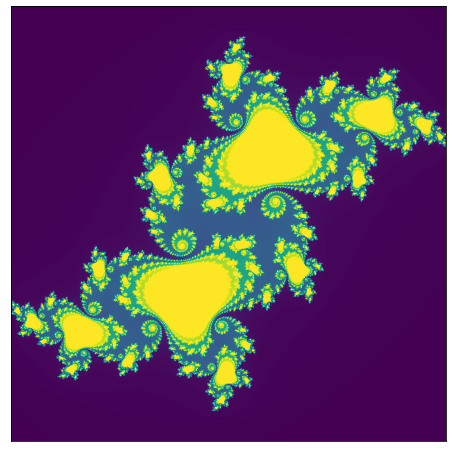

In [2]:
canvas = make_canvas(julia, 0, 0, 2.5, 800, kws=dict(c=-0.1+0.65j, orbits=255))
visualize(canvas)

What do we expect of those functions?

In [3]:
help(make_canvas)

Help on function make_canvas in module fractal.visualize:

make_canvas(fn, x, y, size, pixels, kws={})
    Create a 'canvas' based on an arbitrary function fn:ℂ🠖ℕ
    
    fn:     function visualized
    x:      lower-left (smallest) real coordinate
    y:      lower-left (smallest) imaginary coordinate
    size:   numeric range of value to plot in each coord
    pixels: size of generated graph in pixels (square)
    
    Canvas is NumPy array of dtype uint8 (0 <= n <= 255)



In [4]:
help(visualize)

Help on function visualize in module fractal.visualize:

visualize(canvas)
    Visualize an arbitrary canvas of 8-bit unsigned ints



The `visualize()` function is not going to have much to test in an automated way since it returns no value, but only renders a graph.  We can think of a number of properties we'd like `make_canvas()` to have.

It is somewhat difficult to say what values we would expect each pixel value to be in a fractal, other than by computing it.  But with a simple function we can reason more easily.

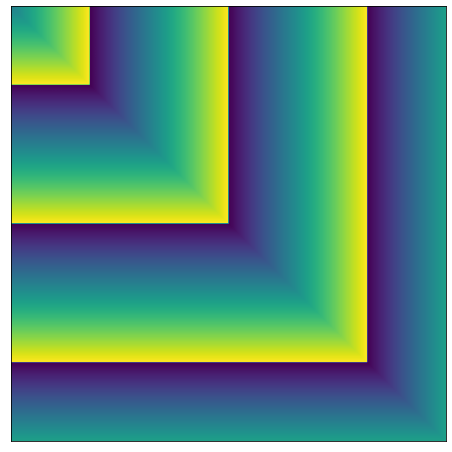

In [5]:
def simple(c):
    return max(int(c.real), int(c.imag)) % 255

canvas = make_canvas(simple, 0, 0, 800, 800)
visualize(canvas)

## Developing tests

For this lesson, we will incrementally expand `test_canvas.py` to include additional tests.  In real code, you will simply add methods within the same file.

A test file may contain multiple classes, and each class may contain multiple tests.  Let's look at a first pass at this test file:

In [6]:
# %load Fractal/test/test_canvas_A.py
import unittest
from random import randrange
from fractal.visualize import *

class TestCanvas(unittest.TestCase):
    "Test that a canvas has expected properties"
    def setUp(self):
        self.min_pix_val = 0
        self.max_pix_val = 255
        self.base_canvas = make_canvas(self.simple_fn, 0, 0, 800, 800)

    def simple_fn(self, c):
        return max(int(c.real), int(c.imag)) % 255

    def test_canvas_size(self):
        for n in range(8):
            pixels = 2**n
            size = randrange(0, pixels)
            canvas = make_canvas(self.simple_fn, 0, 0, size, pixels)
            self.assertEqual(canvas.shape, (pixels, pixels), 
                             msg=f"Unexpected canvas size {canvas.shape}")
    
    def tearDown(self):
        # clean up resources here...
        pass
    
#if __name__ == '__main__':
#    unittest.main()

It is common to name the test classes in a similar manner to the filenames they live inside, but there is no specific requirement.  However, class names should start with "Test".  

The methods that consitute tests must start with `test_`.  The methods `setUp()` and `tearDown()` are special.  Other methods may also be defined.  In this case, the simple function for computing a value based on a complex input is defined as the method `simple_fn()`.

`setUp()` configures a system in such a way to enable a suite of tests to be performed.  Shared data as instance attributes are a simple example; actions like opening files, sockets, web resources, database connections, creating temporary files, and so on are common as well.  `tearDown()` correspondingly, cleans up those resources if needed, after all the tests have run.

The `__main__` block is commented out in this file, but if it is enabled, you can simply run the script to perform the tests (it does not work right within a notebook).  Usually, however, you run tests via the `unittest` module; or indirectly in CI (continuous integration) frameworks such as  Buildbot, Jenkins or Travis-CI, GitHub Actions, or AppVeyor.

Using the module, we can launch tests with varying specificity.  For example, to run one test in one class (which will still be setup and torn down):

In [7]:
!python -m unittest test.test_canvas_A.TestCanvas.test_canvas_size

.
----------------------------------------------------------------------
Ran 1 test in 0.562s

OK


To run every test in the class (only one in this iteration):

In [8]:
!python -m unittest test.test_canvas_A.TestCanvas

.
----------------------------------------------------------------------
Ran 1 test in 0.550s

OK


To run every test in the file (again, just one until next version):

In [9]:
!python -m unittest test.test_canvas_A

.
----------------------------------------------------------------------
Ran 1 test in 0.535s

OK


We can also run tests within a notebook or other environment. For example:

In [10]:
test_canvas = TestCanvas()
print(test_canvas.test_canvas_size())

None


Returning `None` indicates success.

In a few more slides, we will discover all test methods in all classes in all files using:

```bash
python -m unittest discover -s test
```

## Adding tests

In a next iteration, we would like to test not only the size of the canvas generated, but also some properties of the values within the canvas.  For example, we can add these methods.

```python
class TestCanvas(unittest.TestCase):
    # ... prior stuff ...
    def test_canvas_type(self):
        self.assertIsInstance(self.base_canvas, np.ndarray)
        
    def test_min_max(self):
        self.assertTrue(self.base_canvas.max() <= self.max_pix_val)
        self.assertIn(self.base_canvas.min(), [0, 1, 2])  # actually 0

    def test_val_distribution(self):
        # simple_fn has approx equal value distribution along diagonal
        diag = np.diag(self.base_canvas)
        vals, counts = np.unique(diag, return_counts=True)
        self.assertFalse(counts.max() > counts.min() + 1)
```

In [11]:
!python -m unittest test.test_canvas_B

....
----------------------------------------------------------------------
Ran 4 tests in 2.110s

OK


## Failing tests

So far, we have written tests that pass.  But what has been presented also has a subtle bug in it that you may have missed.  Remember the described behavior of `make_canvas()`?

In [12]:
help(make_canvas)

Help on function make_canvas in module fractal.visualize:

make_canvas(fn, x, y, size, pixels, kws={})
    Create a 'canvas' based on an arbitrary function fn:ℂ🠖ℕ
    
    fn:     function visualized
    x:      lower-left (smallest) real coordinate
    y:      lower-left (smallest) imaginary coordinate
    size:   numeric range of value to plot in each coord
    pixels: size of generated graph in pixels (square)
    
    Canvas is NumPy array of dtype uint8 (0 <= n <= 255)



Let us add a testing class to verify the documentation.

```python
# ... imports and class TestCanvas ...

class TestCanvasDocs(unittest.TestCase):
    def setUp(self):
        self.fn = lambda c: max(int(c.real), int(c.imag)) % 255
        self.canvas = make_canvas(self.fn, 0, 0, 800, 800)
        
    def test_position_values(self):
        "Verify values in correct place on canvas"
        for x in range(0, 100, 10):
            for y in range(50, 150, 10):
                self.assertEqual(self.canvas[x, y], self.fn(x+y*1j),
                                 msg=f"Error for simple_fn({x}+{y}j)")
```

In [13]:
!python -m unittest discover -s test

.........F
FAIL: test_position_values (test.test_canvas_C.TestCanvasDocs)
Verify values in correct place on canvas
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/dmertz/git/INE/unittest/02-Unittest/Fractal/test/test_canvas_C.py", line 51, in test_position_values
    self.assertEqual(self.canvas[x, y], self.fn(x+y*1j),
AssertionError: 160 != 50 : Error for simple_fn(0+50j)

----------------------------------------------------------------------
Ran 10 tests in 5.396s

FAILED (failures=1)


The problem is that the docstring claims the smallest coordinates are calculated at the lowest index position.  But if we look at the actual code in `make_canvas()`, we see something different:

```python
real = x - (size/2) + (size * col/xspan)
imag = y - (size/2) + (size * row/yspan)
```

Thinking about that, we realize that the `x` and `y` passed to the function actually indicate the **center** of the canvas, with the size symmerically distributed around that.  We need to decide whether the code or the documentation is the source of the error (both are plausible), and adjust accordingly.  

We have discovered they are **inconsistent**, in any case.